In [1]:
# !pip install --user scikit-image
# !pip install --upgrade python-bidi
# !pip install torchmetrics

In [2]:
import sys
sys.path.append("./EasyOCR")

In [3]:
import json
import os
import random
import importlib
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict
from tqdm import tqdm
from PIL import Image
from torch.optim import AdamW
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from pythainlp.tokenize import word_tokenize
from easyocr.utils import CTCLabelConverter
from easyocr.config import recognition_models
from easyocr.easyocr import Reader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device : {device}')

Device : cuda


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset

In [5]:
class ResizeNormalize(object):
    """
    Custom transform to resize image height to a fixed value (imgH)
    while maintaining the aspect ratio. The width is rescaled accordingly.
    """
    def __init__(self, imgH=32):
        self.imgH = imgH

    def __call__(self, img):
        w, h = img.size
        # To handle cases where the aspect ratio makes the width 0
        new_w = max(int(w * self.imgH / h), 1)
        img = img.resize((new_w, self.imgH), Image.Resampling.BICUBIC)
        return img

class EasyOCRDataset(Dataset):
    def __init__(self, data_root, converter, img_height=32, gt_filename="train_list.txt"):
        """
        Filters the dataset to include only samples with characters recognized by the provided converter.

        data_root/
        ├── train_list.txt          # lines: th_img/0/<word_1>.png\t<label>
        └── th_dict.txt
        └── 0/
            ├ <word_1>.jpg
            ├ <word_2>.jpg
            └ ...
        """
        self.data_root = data_root
        self.image_dir = os.path.join(data_root, "train")
        gt_path = os.path.join(data_root, gt_filename)

        # The set of characters that the model recognizes
        self.recognized_chars = set(converter.character)

        # Read gt.txt and filter samples
        self.samples = []
        unrecognized_samples_count = 0
        with open(gt_path, "r", encoding="utf-8") as f:
            for line in f:
                rel_path, label = line.strip().split("\t", 1)

                # Check if all characters in the label are recognized
                if all(char in self.recognized_chars for char in label):
                    self.samples.append((rel_path, label))
                else:
                    unrecognized_samples_count += 1
        
        if unrecognized_samples_count > 0:
            print(f"INFO: Excluded {unrecognized_samples_count} samples from {gt_filename} due to unrecognized characters.")

        # Transforms: Resize height (variable width) -> grayscale -> tensor -> normalize
        self.transform = transforms.Compose([
            ResizeNormalize(imgH=img_height),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rel_path, label = self.samples[idx]
        # In this example, the relative path is the actual path
        img_path = rel_path

        # Load & transform
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)  # [1, H, W]

        return image, label

In [6]:
def collate_fn(batch):
    """
    Custom collate function to handle images of variable width.
    It pads all images in the batch to the maximum width.
    """
    images, labels = zip(*batch)
    
    # Find the maximum width in the batch
    max_width = max(img.shape[2] for img in images)
    
    # Pad images to the max_width
    padded_images = []
    for img in images:
        # F.pad format: (pad_left, pad_right, pad_top, pad_bottom)
        padding = (0, max_width - img.shape[2], 0, 0)
        padded_img = F.pad(img, padding, 'constant', 0.5) # Pad with normalized value
        padded_images.append(padded_img)
        
    # Stack images into a single tensor
    images = torch.stack(padded_images, 0)
    
    return images, labels

In [7]:
IMG_HEIGHT = 64

# Step 1: Initialize Reader for Thai
reader = Reader(['th'], gpu=True)
character_set = reader.character  # this is the character set used by the model

# === Step 2: Prepare Character Set and Converter ===
# Load the base character set from your dictionary file
lang = 'th'
recog_network = 'generation1'
model_config = recognition_models['gen1']['thai_g1']

# This is the definitive set of characters your model will recognize
character = character_set
model_path = f'./pretrained/{model_config["filename"]}'

# Initialize the converter with this base character set
converter = CTCLabelConverter(character)
num_class = len(converter.character)
ignore_idx = []
print(f"✅ Initialized CTCLabelConverter with {len(converter.character)} characters from the dictionary.")
print("-" * 50)

# === Step 3: Load and Filter Datasets ===
# Pass the converter to the dataset to handle filtering internally
train_dataset = EasyOCRDataset("./th_img", converter=converter, img_height=IMG_HEIGHT, gt_filename="train_list.txt")
valid_dataset = EasyOCRDataset("./th_img", converter=converter, img_height=IMG_HEIGHT, gt_filename="val_list.txt")

print(f"\nOriginal train samples: [some number], Filtered train samples: {len(train_dataset)}")
print(f"Original validation samples: [some number], Filtered validation samples: {len(valid_dataset)}")
print("-" * 50)

✅ Initialized CTCLabelConverter with 177 characters from the dictionary.
--------------------------------------------------
INFO: Excluded 10264 samples from train_list.txt due to unrecognized characters.
INFO: Excluded 96 samples from val_list.txt due to unrecognized characters.

Original train samples: [some number], Filtered train samples: 187731
Original validation samples: [some number], Filtered validation samples: 1904
--------------------------------------------------


In [8]:
# === Step 4: Create DataLoaders ===
seed = 42
batch_size = 32
generator = torch.Generator().manual_seed(seed)

# Shuffle indices manually
indices = list(range(len(train_dataset)))
random.Random(seed).shuffle(indices)

# # Take only the first 100000 shuffled indices
# limited_indices = indices[:100000]
limited_indices = indices[:]

# Create a shuffled subset
shuffled_train_set = Subset(train_dataset, limited_indices)

# Split lengths
train_len = len(shuffled_train_set)
val_test_len = len(valid_dataset)
valid_len = int(val_test_len * 0.5)
test_len = val_test_len - valid_len

# Split the dataset
valid_set, test_set = random_split(valid_dataset, [valid_len, test_len], generator=generator)

# Create DataLoaders
# train_loader = DataLoader(shuffled_train_set, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
# test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)
train_loader = DataLoader(
    shuffled_train_set, 
    batch_size=batch_size, 
    shuffle=True, 
    generator=generator, 
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_set, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_set, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn
)

In [9]:
# simple validation loop
def validate(model, loader, converter, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)           # raw CTC logits
            preds  = converter.decode(logits.softmax(-1))
            for p,t in zip(preds, labels):
                if p == t: correct += 1
                total  += 1
    return correct/total

In [10]:
print(f'Len Training data : {train_len}')

Len Training data : 187731


In [11]:
print(f'Len Valid data : {valid_len}')

Len Valid data : 952


In [12]:
print(f'Len Test data : {test_len}')

Len Test data : 952


In [13]:
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 1, 64, 473])
('ละทิ้งหน้าที่', 'จิโอเกตโต้', 'ขัดแย้งกัน?', '22.00', 'และตบที่กกหู', 'พ.ต.ท.สุริยันต์', 'บ้านมายอ', 'Thida:', 'ระหว่างสพธอ.กับ', 'น.นายสมชัย', 'ก็อธิบายไปว่า', '33.64', 'กับบรรดาขุนศึก', 'ต้องดู', 'และถูกปิดอีก', 'ลักษณะชนชั้น', "'ยาใจคนจน", 'เมืองทาคีตา', 'ตรงนี้ครับ', 'มงดอว์', '2519-23', 'สอเฮาะ', 'ทรัพย์พ่วง', 'และนายมะมิง', 'อ้างราคาตลาดโลก', 'Aneshensel', 'เจ๊ใหญ่', 'โรคช่องปาก', 'หรือภาษาแม่ได้', 'การแบ่งแยกไปให้', 'GPP', 'ดังเป็นพลุแตก')


In [14]:
labels

('ละทิ้งหน้าที่',
 'จิโอเกตโต้',
 'ขัดแย้งกัน?',
 '22.00',
 'และตบที่กกหู',
 'พ.ต.ท.สุริยันต์',
 'บ้านมายอ',
 'Thida:',
 'ระหว่างสพธอ.กับ',
 'น.นายสมชัย',
 'ก็อธิบายไปว่า',
 '33.64',
 'กับบรรดาขุนศึก',
 'ต้องดู',
 'และถูกปิดอีก',
 'ลักษณะชนชั้น',
 "'ยาใจคนจน",
 'เมืองทาคีตา',
 'ตรงนี้ครับ',
 'มงดอว์',
 '2519-23',
 'สอเฮาะ',
 'ทรัพย์พ่วง',
 'และนายมะมิง',
 'อ้างราคาตลาดโลก',
 'Aneshensel',
 'เจ๊ใหญ่',
 'โรคช่องปาก',
 'หรือภาษาแม่ได้',
 'การแบ่งแยกไปให้',
 'GPP',
 'ดังเป็นพลุแตก')

ละทิ้งหน้าที่
จิโอเกตโต้
ขัดแย้งกัน?
22.00
และตบที่กกหู
พ.ต.ท.สุริยันต์
บ้านมายอ
Thida:


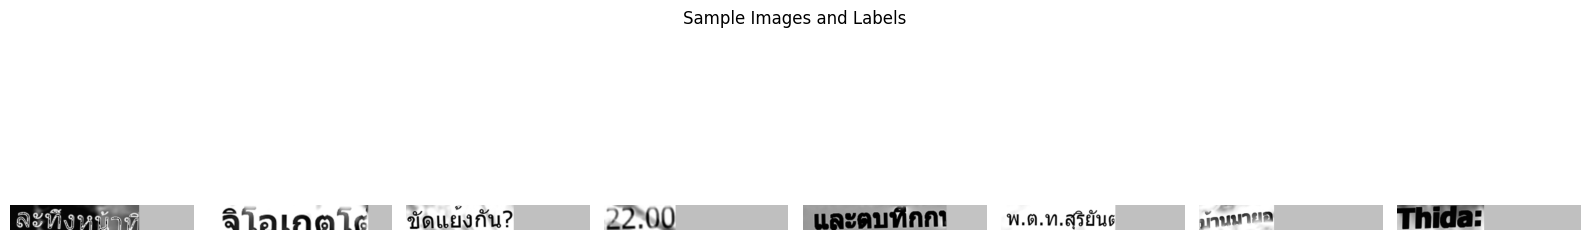

In [15]:
# Pick a few samples to display
num_to_display = 8
images_to_show = images[:num_to_display]
labels_to_show = labels[:num_to_display]

# Denormalize images (from [-1, 1] back to [0, 1])
images_to_show = images_to_show * 0.5 + 0.5  # Because normalized with mean=0.5, std=0.5

# Plot
plt.figure(figsize=(16, 4))
for i in range(num_to_display):
    img = images_to_show[i].squeeze(0).cpu().numpy()  # shape: [32, 160]
    print(labels_to_show[i][:30])

    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(img, cmap='gray')
    #plt.title(f"{labels_to_show[i][:30]}...", fontsize=8)  # Truncate long text
    plt.axis('off')

plt.suptitle("Sample Images and Labels", fontsize=12)
plt.tight_layout()
plt.show()

# Model

In [16]:
network_params = {
    'input_channel': 1,
    'output_channel': 512,
    'hidden_size': 512
}

# network_params = {
#     'Transformation': 'None',
#     'FeatureExtraction': 'VGG',
#     'SequenceModeling': 'BiLSTM',
#     'Prediction': 'CTC',
#     'input_channel': 1,
#     'output_channel': 512,
#     'hidden_size': 512
# }

# === Step 3: Load Model with Strict Check ===
model_pkg = importlib.import_module("easyocr.model.model")
model = model_pkg.Model(num_class=num_class, **network_params)

state_dict = torch.load(model_path, map_location=device)
new_state_dict = OrderedDict((k[7:], v) if k.startswith("module.") else (k, v) for k, v in state_dict.items())

load_result = model.load_state_dict(new_state_dict, strict=False)
if load_result.missing_keys or load_result.unexpected_keys:
    print("⚠️ Weight loading issues:")
    if load_result.missing_keys:
        print("Missing keys:", load_result.missing_keys)
    if load_result.unexpected_keys:
        print("Unexpected keys:", load_result.unexpected_keys)
    raise ValueError("Model weights mismatch. Aborting due to strict=True policy.")
    

model.load_state_dict(new_state_dict, strict=True)
model = model.to(device)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16740\1981384956.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


In [17]:
# import torch
# from torchvision import transforms
# from PIL import Image, ImageEnhance
# from collections import OrderedDict
# import importlib
# import numpy as np
# import torch.nn.functional as F

# from easyocr.utils import CTCLabelConverter
# from easyocr.config import recognition_models

In [18]:
# def get_labels_from_txt(label_path, delim="\t"):
#     all_labels = []
#     with open(label_path, "r", encoding="utf-8") as f:
#         for line in f:
#             rel_path, label = line.strip().split(delim, 1)
#             all_labels.append(label)

#     return all_labels

In [19]:
# # === Step 1: Prepare Model Config ===
# lang = 'th'
# recog_network = 'generation1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model_config = recognition_models['gen1']['thai_g1']

# # read th_dict.txt into a list of labels
# dict_path = "th_img/th_dict.txt"
# chars = []

# with open(dict_path, "r", encoding="utf-8") as f:
#     for line in f:
#         char = line.split("\n", -1)[0]
#         chars.append(char)

# # Create a set of all unique characters present in your text dictionary
# base_character_set = "".join(set("".join(chars)))

# # read train_list.txt into a list of labels
# all_labels = get_labels_from_txt("th_img/train_list.txt")
# val_labels = get_labels_from_txt("th_img/val_list.txt")
# all_labels.extend(val_labels)

# # Create a set of all unique characters present in your text data
# all_chars_from_text = set("".join(all_labels))
# # Convert your base character set to a set for easy comparison
# existing_chars_set = set(base_character_set)
# newly_found_chars = all_chars_from_text - existing_chars_set

# character_set = base_character_set

# if newly_found_chars:
#     # Sort the new characters for consistent ordering
#     new_chars_to_add = "".join(sorted(list(newly_found_chars)))
    
#     print(f"✅ Found {len(new_chars_to_add)} new character(s) missing from your set:")
#     print(f"   New Characters: {new_chars_to_add}")
    
#     # Append the new characters to your base set
#     character_set += new_chars_to_add
    
#     print(f"\nUpdated character set size: {len(character_set)}")

# else:
#     print("✅ No new characters were found.")
#     print("   Your character set is already complete for this data.")

# print("-" * 50)

In [20]:
# # Use the custom character set
# character = character_set
# model_path = f'./pretrained/{model_config["filename"]}'

# # === Step 2: Setup Converter & Params ===
# converter = CTCLabelConverter(character)
# num_class = len(converter.character)
# # The ignore_idx is handled by the converter, no need to set it manually

# network_params = {
#     'input_channel': 1,
#     'output_channel': 512,
#     'hidden_size': 512,
#     'num_class': num_class  # Pass num_class to the model constructor
# }

# # === Step 3: Load Model with Strict Check ===
# model_pkg = importlib.import_module("easyocr.model.model")
# # Ensure the model architecture matches what you're loading
# # If you are using a custom model, you might need to adjust this.
# # For standard models, the network_params should be sufficient.
# model = model_pkg.Model(**network_params)

# # It's generally better to load the pretrained model first and then
# # adapt the final classification layer for your custom number of classes.

# # Load the pretrained weights
# state_dict = torch.load(model_path, map_location=device)
# # First, create the new state_dict by stripping the 'module.' prefix
# new_state_dict = OrderedDict((k[7:], v) if k.startswith("module.") else (k, v) for k, v in state_dict.items())

# # **DEBUG**: Print all the keys in the new state_dict to see what's available
# print("Keys available in the model's state_dict:")
# print(list(new_state_dict.keys()))
# print("-" * 50)


# # Now, access the cleaned key 'Prediction.weight' to get the size
# # Also, add a check to ensure the key exists before accessing it
# prediction_weight_key = 'Prediction.weight'
# if prediction_weight_key not in new_state_dict:
#     raise KeyError(f"The key '{prediction_weight_key}' was not found in the model state_dict. "
#                    f"Please check the printed keys above to find the correct key for the final prediction layer's weights.")

# pretrained_num_class = new_state_dict[prediction_weight_key].shape[0]

# # If the number of classes is different, re-initialize the final layer.
# if num_class != pretrained_num_class:
#     print(f"⚠️ Number of classes differs. Pretrained model has {pretrained_num_class}, your model has {num_class}.")
#     print("Re-initializing the final prediction layer.")
#     # Remove the old prediction layer weights so they aren't loaded
#     del new_state_dict['Prediction.weight']
#     del new_state_dict['Prediction.bias']

#     # Load all other weights with strict=False
#     load_result = model.load_state_dict(new_state_dict, strict=False)
#     print("Missing keys:", load_result.missing_keys) # Should be ['Prediction.weight', 'Prediction.bias']
#     print("Unexpected keys:", load_result.unexpected_keys)

# else:
#     # If number of classes is the same, load everything strictly
#     model.load_state_dict(new_state_dict, strict=True)

# model = model.to(device)

# print("\n✅ Model setup complete with the custom character set.")
# print(f"Character set contains {len(character)} characters.")

In [21]:
len(character)

176

In [22]:
# Folder setup
metrics_dir = "metrics/synth-v4"
model_dir = "models/synth-v4"
os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# The path where you want to save the file
char_file_path = os.path.join(model_dir, "custom_char.txt")

try:
    # Use 'utf-8' encoding, which is crucial for handling Thai characters
    with open(char_file_path, 'w', encoding='utf-8') as f:
        f.write(character_set)
    
    print(f"✅ Character set successfully saved to: {char_file_path}")
    print(f"\tTotal characters saved: {len(character_set)}")

except Exception as e:
    print(f"⚠️ An error occurred: {e}")

✅ Character set successfully saved to: models/synth-v4\custom_char.txt
	Total characters saved: 176


In [23]:
for param in model.FeatureExtraction.parameters():
    param.requires_grad = False
for param in model.FeatureExtraction.ConvNet.layer4.parameters():
    param.requires_grad = True

In [24]:
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🔒 Frozen parameters: {frozen_params:,}")
print(f"🟢 Trainable parameters: {trainable_params:,}")
print(f"📊 Total parameters: {frozen_params + trainable_params:,}")

🔒 Frozen parameters: 30,101,984
🟢 Trainable parameters: 23,707,313
📊 Total parameters: 53,809,297


In [25]:
import torch.nn as nn
import torch.optim as optim

criterion = torch.nn.CTCLoss(zero_infinity=True).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Train

c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Epoch 1/10 [Training]: 100%|██████████| 5867/5867 [40:17<00:00,  2.43it/s, loss=0.108]  


Epoch 1: Train Loss = 0.1081
⚠️ Skipped 1 empty predictions this epoch
Validation Loss = 0.0698 | CER = 0.0162 | WER = 0.1283
✅ New best model saved to: models/synth-v4\thai.pth (CER: 0.0162)


Epoch 2/10 [Training]: 100%|██████████| 5867/5867 [31:28<00:00,  3.11it/s, loss=0.0571] 


Epoch 2: Train Loss = 0.0571
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0434 | CER = 0.0112 | WER = 0.0830
✅ New best model saved to: models/synth-v4\thai.pth (CER: 0.0112)
✅ Checkpoint 2 saved to: models/synth-v4\checkpoint_2.pth

🔍 Debug Sample Predictions (Epoch 2, First 10):
GT   : 'ที่ใหญ่อันดับ'
PRED : 'ที่ใหญ่อันดับ'
---
GT   : 'เพลงเดือนดับ'
PRED : 'เพลงเดือนดับ'
---
GT   : 'เวบไซต์ด้วยกัน'
PRED : 'เวบไซต์ด้วยกัน'
---
GT   : 'ในฐานะผู้หญิง'
PRED : 'ในฐานะผู้หญิง'
---
GT   : 'เปรูและชิลี'
PRED : 'เปรูและชิจิ'
---
GT   : 'หรืออยู่กับใคร'
PRED : 'หรืออยู่กับใคร'
---
GT   : 'คนส่วนใหญ่ไม่มี'
PRED : 'คนส่วนใหญ่ไม่ดี'
---
GT   : 'กับสยาม'
PRED : 'กับสยาม'
---
GT   : 'เจ้าของสิทธิ'
PRED : 'เจ้าของสิทธิ'
---
GT   : 'เสียงจากรถแดง'
PRED : 'เสียงจากรถแดง'
---


Epoch 3/10 [Training]: 100%|██████████| 5867/5867 [30:31<00:00,  3.20it/s, loss=0.033]   


Epoch 3: Train Loss = 0.0330
⚠️ Skipped 1 empty predictions this epoch
Validation Loss = 0.0354 | CER = 0.0088 | WER = 0.0673
✅ New best model saved to: models/synth-v4\thai.pth (CER: 0.0088)


Epoch 4/10 [Training]: 100%|██████████| 5867/5867 [31:00<00:00,  3.15it/s, loss=0.0213]  


Epoch 4: Train Loss = 0.0213
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0314 | CER = 0.0090 | WER = 0.0693
✅ Checkpoint 4 saved to: models/synth-v4\checkpoint_4.pth

🔍 Debug Sample Predictions (Epoch 4, First 10):
GT   : 'ที่ใหญ่อันดับ'
PRED : 'ที่ใหญ่อันดับ'
---
GT   : 'เพลงเดือนดับ'
PRED : 'เพลงเดือนดับ'
---
GT   : 'เวบไซต์ด้วยกัน'
PRED : 'เวบไซต์ด้วยกัน'
---
GT   : 'ในฐานะผู้หญิง'
PRED : 'ในฐานะผู้หญิง'
---
GT   : 'เปรูและชิลี'
PRED : 'เปรูและชิลี'
---
GT   : 'หรืออยู่กับใคร'
PRED : 'หรืออยู่กับใคร'
---
GT   : 'คนส่วนใหญ่ไม่มี'
PRED : 'คนส่วนใหญ่ไม่มี'
---
GT   : 'กับสยาม'
PRED : 'กับสยาม'
---
GT   : 'เจ้าของสิทธิ'
PRED : 'เจ้าของสิทธิ'
---
GT   : 'เสียงจากรถแดง'
PRED : 'เสียงจากรถแดง'
---


Epoch 5/10 [Training]: 100%|██████████| 5867/5867 [30:57<00:00,  3.16it/s, loss=0.0642]  


Epoch 5: Train Loss = 0.0642
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0310 | CER = 0.0075 | WER = 0.0620
✅ New best model saved to: models/synth-v4\thai.pth (CER: 0.0075)


Epoch 6/10 [Training]: 100%|██████████| 5867/5867 [38:37<00:00,  2.53it/s, loss=0.012]   


Epoch 6: Train Loss = 0.0120
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0309 | CER = 0.0076 | WER = 0.0620
✅ Checkpoint 6 saved to: models/synth-v4\checkpoint_6.pth

🔍 Debug Sample Predictions (Epoch 6, First 10):
GT   : 'ที่ใหญ่อันดับ'
PRED : 'ที่ใหญ่อันดับ'
---
GT   : 'เพลงเดือนดับ'
PRED : 'เพลงเดือนดับ'
---
GT   : 'เวบไซต์ด้วยกัน'
PRED : 'เวบไซต์ด้วยกัน'
---
GT   : 'ในฐานะผู้หญิง'
PRED : 'ในฐานะผู้หญิง'
---
GT   : 'เปรูและชิลี'
PRED : 'เปรูและชิลี'
---
GT   : 'หรืออยู่กับใคร'
PRED : 'หรืออยู่กับใคร'
---
GT   : 'คนส่วนใหญ่ไม่มี'
PRED : 'คนส่วนใหญ่ไม่มี'
---
GT   : 'กับสยาม'
PRED : 'กับสยาม'
---
GT   : 'เจ้าของสิทธิ'
PRED : 'เจ้าของสิทธิ'
---
GT   : 'เสียงจากรถแดง'
PRED : 'เสียงจากรถแดง'
---


Epoch 7/10 [Training]: 100%|██████████| 5867/5867 [33:23<00:00,  2.93it/s, loss=0.00717] 


Epoch 7: Train Loss = 0.0072
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0351 | CER = 0.0075 | WER = 0.0567


Epoch 8/10 [Training]: 100%|██████████| 5867/5867 [30:54<00:00,  3.16it/s, loss=0.0088]  


Epoch 8: Train Loss = 0.0088
⚠️ Skipped 1 empty predictions this epoch
Validation Loss = 0.0355 | CER = 0.0066 | WER = 0.0505
✅ New best model saved to: models/synth-v4\thai.pth (CER: 0.0066)
✅ Checkpoint 8 saved to: models/synth-v4\checkpoint_8.pth

🔍 Debug Sample Predictions (Epoch 8, First 10):
GT   : 'ที่ใหญ่อันดับ'
PRED : 'ที่ใหญ่อันดับ'
---
GT   : 'เพลงเดือนดับ'
PRED : 'เพลงเดือนดับ'
---
GT   : 'เวบไซต์ด้วยกัน'
PRED : 'เวบไซต์ด้วยกัน'
---
GT   : 'ในฐานะผู้หญิง'
PRED : 'ในฐานะผู้หญิง'
---
GT   : 'เปรูและชิลี'
PRED : 'เปรูและชิลี'
---
GT   : 'หรืออยู่กับใคร'
PRED : 'หรืออยู่กับใคร'
---
GT   : 'คนส่วนใหญ่ไม่มี'
PRED : 'คนส่วนใหญ่ไม่พี'
---
GT   : 'กับสยาม'
PRED : 'กับสยาม'
---
GT   : 'เจ้าของสิทธิ'
PRED : 'เจ้าของสิทธิ'
---
GT   : 'เสียงจากรถแดง'
PRED : 'เสียงจากรถแดง'
---


Epoch 9/10 [Training]: 100%|██████████| 5867/5867 [31:00<00:00,  3.15it/s, loss=0.00372] 


Epoch 9: Train Loss = 0.0037
⚠️ Skipped 1 empty predictions this epoch
Validation Loss = 0.0289 | CER = 0.0062 | WER = 0.0515
✅ New best model saved to: models/synth-v4\thai.pth (CER: 0.0062)


Epoch 10/10 [Training]: 100%|██████████| 5867/5867 [30:52<00:00,  3.17it/s, loss=0.000744]


Epoch 10: Train Loss = 0.0007
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0340 | CER = 0.0065 | WER = 0.0494
✅ Checkpoint 10 saved to: models/synth-v4\checkpoint_10.pth

🔍 Debug Sample Predictions (Epoch 10, First 10):
GT   : 'ที่ใหญ่อันดับ'
PRED : 'ที่ใหญ่อันดับ'
---
GT   : 'เพลงเดือนดับ'
PRED : 'เพลงเดือนดับ'
---
GT   : 'เวบไซต์ด้วยกัน'
PRED : 'เวบไซต์ด้วยกัน'
---
GT   : 'ในฐานะผู้หญิง'
PRED : 'ในฐานะผู้หญิง'
---
GT   : 'เปรูและชิลี'
PRED : 'เปรูและชิลี'
---
GT   : 'หรืออยู่กับใคร'
PRED : 'หรืออยู่กับใคร'
---
GT   : 'คนส่วนใหญ่ไม่มี'
PRED : 'คนส่วนใหญ่ไม่มี'
---
GT   : 'กับสยาม'
PRED : 'กับสยาม'
---
GT   : 'เจ้าของสิทธิ'
PRED : 'เจ้าของสิทธิ'
---
GT   : 'เสียงจากรถแดง'
PRED : 'เสียงจากรถแดง'
---


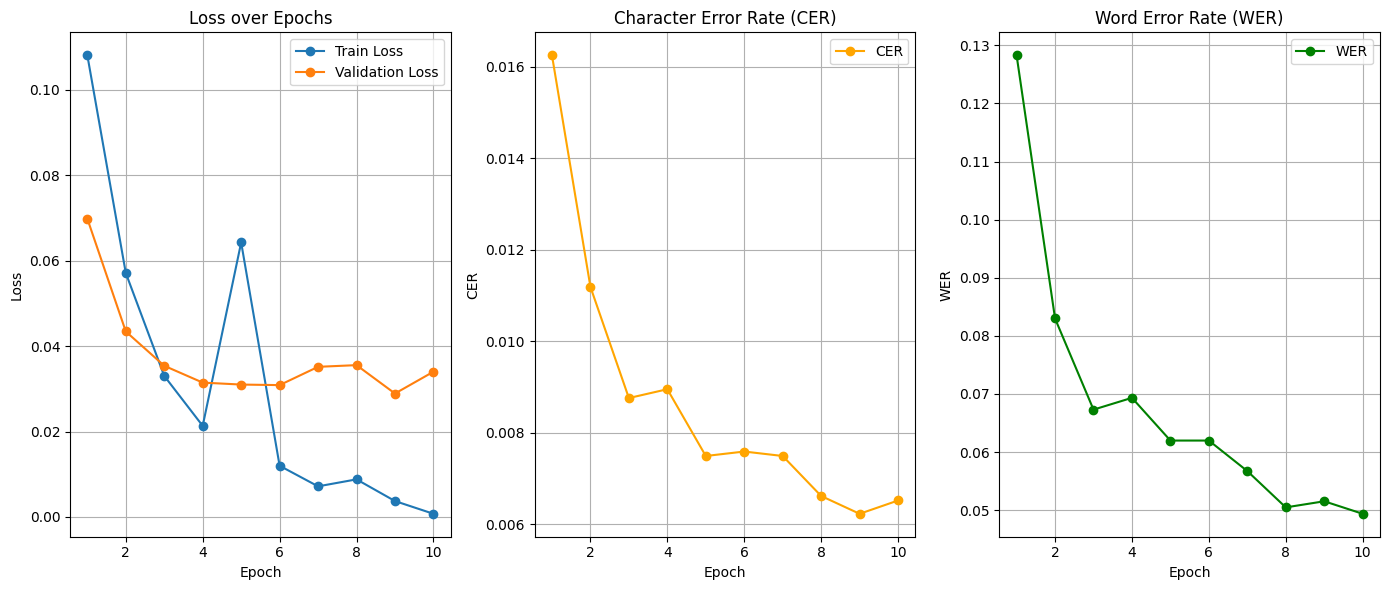

📊 Metrics plot saved to: metrics/synth-v4\training_metrics.png


In [26]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.text import CharErrorRate, WordErrorRate

# === Assume these are already defined ===
# model, optimizer, criterion, converter, train_loader, valid_loader, device

def clean_text(text):
    return text.strip().replace(" ", "").lower()

# === Training Setup ===
num_epochs = 10

train_losses = []
val_losses = []
cer_list = []
wer_list = []
best_cer = float("inf")

# Initialize torchmetrics metrics
cer_metric = CharErrorRate()
wer_metric = WordErrorRate()

for epoch in range(1, num_epochs + 1):
    # === Training ===
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Training]")
    for images, labels in train_bar:
        images = images.to(device)

        targets, lengths = converter.encode(labels)
        targets = targets.to(device)
        lengths = lengths.to(device)

        preds = model(images, text=targets).log_softmax(2)
        batch_size = images.size(0)
        preds_size = torch.IntTensor([preds.size(1)] * batch_size).to(device)
        preds = preds.permute(1, 0, 2)

        loss = criterion(preds, targets, preds_size, lengths)

        optimizer.zero_grad()
        loss.backward()

        # Add gradient clipping to prevent inf loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()

        # Update the progress bar with current loss
        train_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}")
    train_losses.append(loss.item())

    # === Validation ===
    model.eval()
    val_loss = 0
    preds_str_all = []
    labels_all = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)

            targets, lengths = converter.encode(labels)
            targets = targets.to(device)
            lengths = lengths.to(device)

            preds = model(images, text=targets).log_softmax(2)
            batch_size = images.size(0)
            preds_size = torch.IntTensor([preds.size(1)] * batch_size).to(device)
            preds = preds.permute(1, 0, 2)

            loss = criterion(preds, targets, preds_size, lengths)
            val_loss += loss.item()

            _, preds_index = preds.max(2)  # [B, T]
            preds_index = preds_index.transpose(1, 0).contiguous().view(-1).cpu().numpy()
            preds_size_cpu = preds_size.cpu().numpy()
            preds_str = converter.decode_greedy(preds_index, preds_size_cpu)

            preds_str_all.extend(preds_str)
            labels_all.extend(labels)

    # === Filter out empty preds ===
    preds_filtered = []
    labels_filtered = []
    empty_count = 0

    for p, l in zip(preds_str_all, labels_all):
        if p != "":
            preds_filtered.append(p)
            labels_filtered.append(l)
        else:
            empty_count += 1

    print(f"⚠️ Skipped {empty_count} empty predictions this epoch")

    # === Compute Metrics ===
    if preds_filtered:
        cer = cer_metric(preds_filtered, labels_filtered).item()
        wer = wer_metric(preds_filtered, labels_filtered).item()
    else:
        cer = 1.0
        wer = 1.0
        print("⚠️ No valid predictions to compute metrics for this epoch.")

    avg_val_loss = val_loss / len(valid_loader)

    val_losses.append(avg_val_loss)
    cer_list.append(cer)
    wer_list.append(wer)

    print(f"Validation Loss = {avg_val_loss:.4f} | CER = {cer:.4f} | WER = {wer:.4f}")

    # === Save best model based on CER ===
    if cer < best_cer:
        best_cer = cer
        best_model_path = os.path.join(model_dir, "thai.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved to: {best_model_path} (CER: {cer:.4f})")

    # === Debug: Visual Check on Predictions (every 2 epochs) ===
    if epoch % 2 == 0:
        checkpoint_path = os.path.join(model_dir, f"checkpoint_{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Checkpoint {epoch} saved to: {checkpoint_path}")

        print(f"\n🔍 Debug Sample Predictions (Epoch {epoch}, First 10):")
        for i in range(min(10, len(preds_filtered))):
            print(f"GT   : {labels_filtered[i]!r}")
            print(f"PRED : {preds_filtered[i]!r}")
            print("---")

# === Plotting and Saving Metrics ===
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)

# Plot CER
plt.subplot(1, 3, 2)
plt.plot(epochs, cer_list, label="CER", marker='o', color='orange')
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.title("Character Error Rate (CER)")
plt.legend()
plt.grid(True)

# Plot WER
plt.subplot(1, 3, 3)
plt.plot(epochs, wer_list, label="WER", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("WER")
plt.title("Word Error Rate (WER)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plot_path = os.path.join(metrics_dir, "training_metrics.png")
plt.savefig(plot_path)
plt.show()
print(f"📊 Metrics plot saved to: {plot_path}")